In [39]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from libs import encode_float_filename, decode_float_filename, compute_f1_scores, compute_weighted_f1_score

F1-Scores for each class: 0.39807793049680645
F1-Scores for each class: 0.3218183874571898
Mean Squared Error CF: 1.4262584447860718, Mean Squared Error CA: 1.1407933235168457


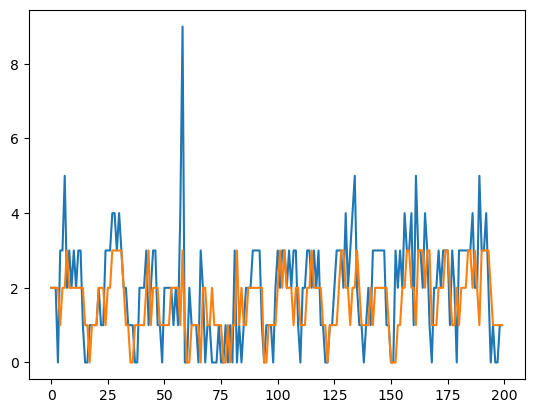

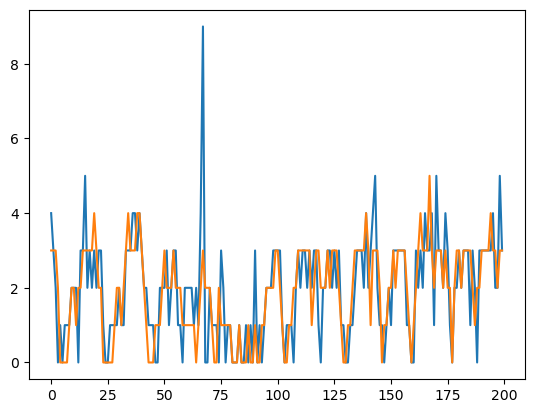

F1-Scores for each class: 0.26853204025938343
F1-Scores for each class: 0.1820814075222694
Mean Squared Error CF: 4.872155666351318, Mean Squared Error CA: 2.8591935634613037


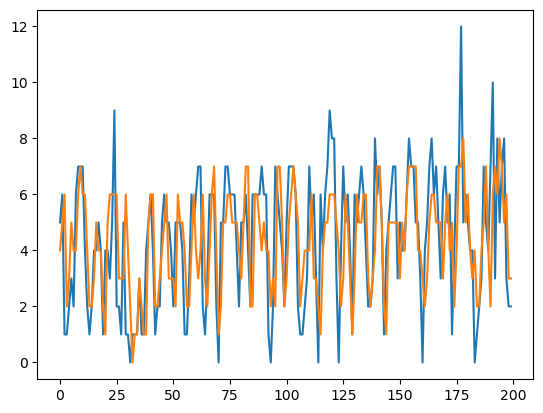

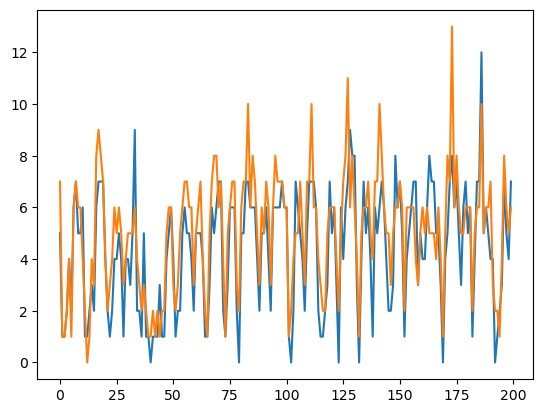

F1-Scores for each class: 0.17854682335394267
F1-Scores for each class: 0.12742433398746675
Mean Squared Error CF: 9.943097114562988, Mean Squared Error CA: 5.365896701812744


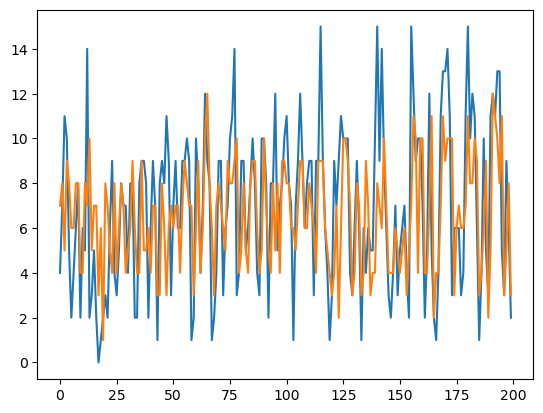

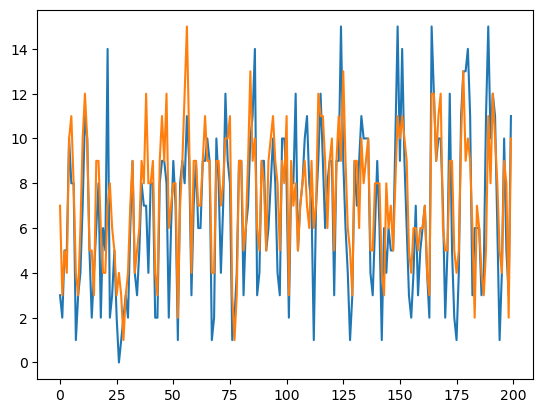

F1-Scores for each class: 0.21322484865044936
F1-Scores for each class: 0.19233792379294135
Mean Squared Error CF: 4.198582649230957, Mean Squared Error CA: 3.439788341522217


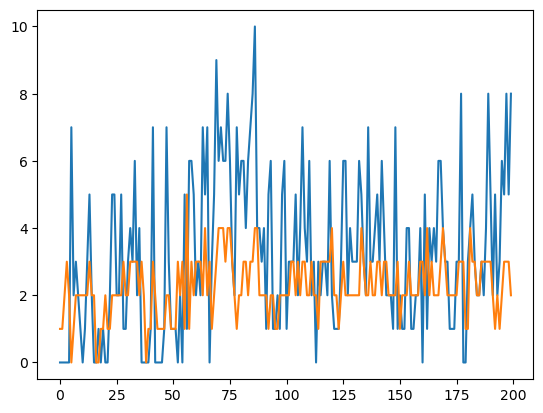

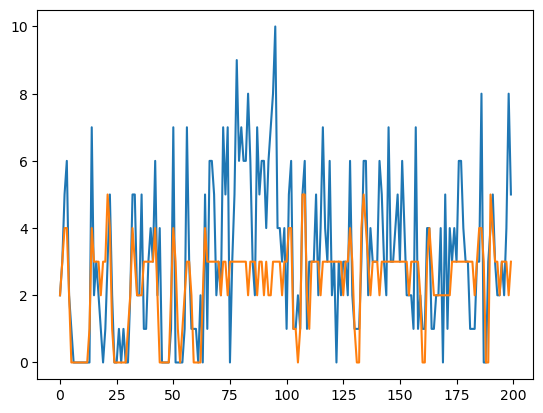

F1-Scores for each class: 0.13659905926181892
F1-Scores for each class: 0.09090765745183159
Mean Squared Error CF: 12.832755088806152, Mean Squared Error CA: 8.319408416748047


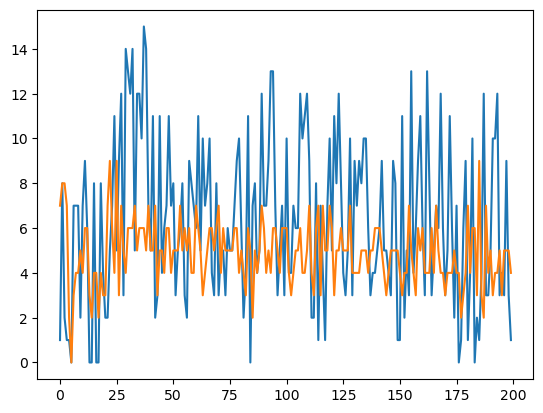

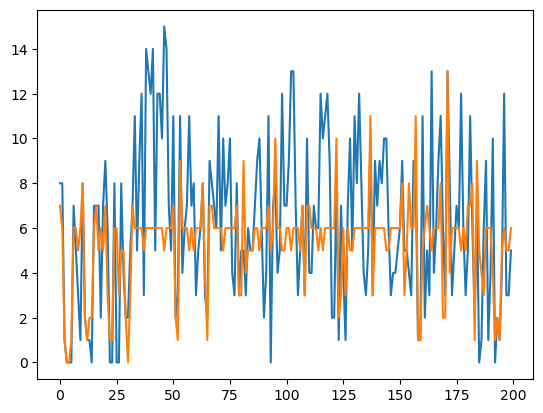

F1-Scores for each class: 0.07312301471729464
F1-Scores for each class: 0.06041898543150178
Mean Squared Error CF: 23.44518280029297, Mean Squared Error CA: 15.453933715820312


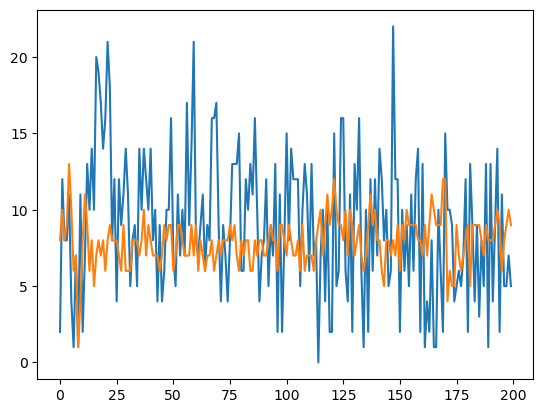

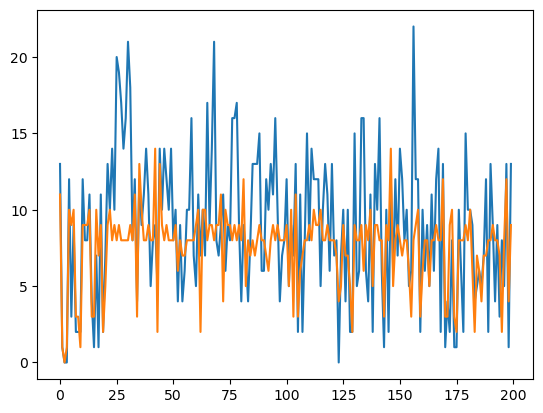

In [ ]:
dbParams_list = [0.01, 0.15]
direction_list = ["forward", "backward"]
#dbParams_list = [0.01]
#direction_list = ["forward"]
mode_list = ["fixed"]
LEN_period = 1000
verbose = False

mseCF_results = {}
mseCA_results = {}
f1ScoreCF_results = {}
f1ScoreCA_results = {}

for dbParams, direction in zip(dbParams_list, direction_list):
    for mode in mode_list:
        perpCF_row = []
        perpCA_row = []
        for lenWindow in [10, 20, 30]:
            dbpString = encode_float_filename(dbParams)
            with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "rb") as file:
                resultsCA_Train = pickle.load(file)
            with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "rb") as file:
                resultsCA_Test = pickle.load(file)
            with open(f"Results/TrafficPredictor/evaluate/CF/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "rb") as file:
                resultsCF_Train = pickle.load(file)
            with open(f"Results/TrafficPredictor/evaluate/CF/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "rb") as file:
                resultsCF_Test = pickle.load(file)
            f1_scores_CA = compute_weighted_f1_score(resultsCA_Test['trafficTarget_predicted'].astype(int), resultsCA_Test['trafficTarget_actual'].astype(int), lenWindow+1)
            f1_scores_CF = compute_weighted_f1_score(resultsCF_Test['trafficTarget_predicted'].astype(int), resultsCF_Test['trafficTarget_actual'].astype(int), lenWindow+1)
            mse_CA = np.mean((resultsCA_Test['trafficTarget_predicted'] - resultsCA_Test['trafficTarget_actual'])**2)
            mse_CF = np.mean((resultsCF_Test['trafficTarget_predicted'] - resultsCF_Test['trafficTarget_actual'])**2)
            '''
            f1_scores = compute_weighted_f1_score(resultsCA_Test['trafficTarget_predicted'].astype(int), resultsCA_Test['trafficTarget_actual'].astype(int), lenWindow+1)
            print(f"F1-Scores for each class: {f1_scores}")
            f1_scores = compute_weighted_f1_score(resultsCF_Test['trafficTarget_predicted'].astype(int), resultsCF_Test['trafficTarget_actual'].astype(int), lenWindow+1)
            print(f"F1-Scores for each class: {f1_scores}")

            mse_CA = np.mean((resultsCA_Test['trafficTarget_predicted'] - resultsCA_Test['trafficTarget_actual'])**2)
            mse_CF = np.mean((resultsCF_Test['trafficTarget_predicted'] - resultsCF_Test['trafficTarget_actual'])**2)
            print(f"Mean Squared Error CF: {mse_CF}, Mean Squared Error CA: {mse_CA}")

            N_obv=200
            plt.plot(resultsCF_Test['trafficTarget_actual'][:N_obv].astype(int))
            plt.plot(resultsCF_Test['trafficTarget_predicted'][:N_obv].astype(int))
            plt.show()
            plt.plot(resultsCA_Test['trafficTarget_actual'][:N_obv].astype(int))
            plt.plot(resultsCA_Test['trafficTarget_predicted'][:N_obv].astype(int))
            plt.show()
            '''

F1-Scores for each class: 0.26853204025938343
F1-Scores for each class: 0.1820814075222694
Mean Squared Error CF: 4.872155666351318, Mean Squared Error CA: 2.8591935634613037


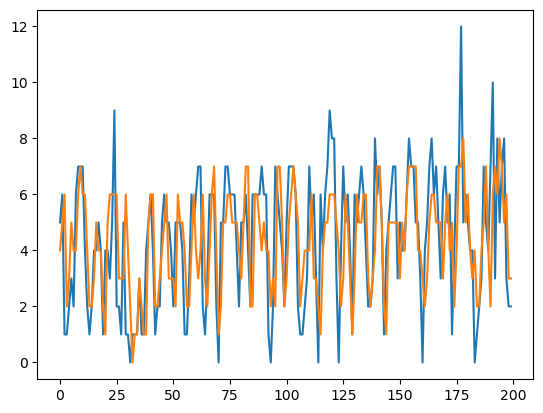

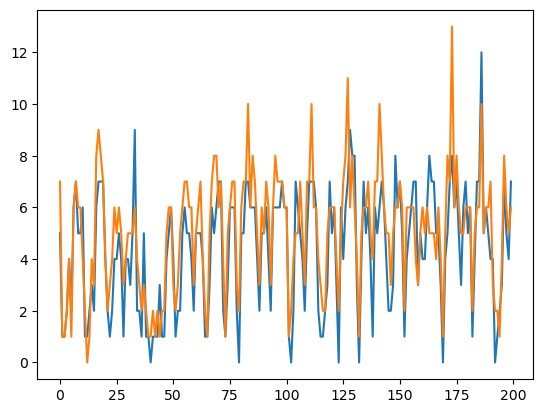